In [1]:

import qiskit.tools.jupyter
import matplotlib as ml
from GenerateRandomCircuit import *
%qiskit_version_table
%qiskit_copyright

To describe the arquitecture of the quantum engine, we construct a graph using networkx.
Edges can be weighted to reflect CNOT error rates. Otherwise their weights should be 1.0 (which is "neutral").

In [2]:
#Example:
V = np.arange(0,5,1)
E =[(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,4,1.0),(4,5,1.0),(3,5,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

Here is a little selection of IBMs quantum engines as graphs:

In [3]:
V_ibmq_london = np.arange(5)
E_ibmq_london = [(0,1,1.0),(1,2,1.0),(1,3,1.0),(3,4,1.0)]
G_ibmq_london = nx.Graph()
G_ibmq_london.add_nodes_from(V_ibmq_london)
G_ibmq_london.add_weighted_edges_from(E_ibmq_london)

V_ibmq_5_yorktown = np.arange(5)
E_ibmq_5_yorktown = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(2,3,1.0),(2,4,1.0),(3,4,1.0)]
G_ibmq_5_yorktown = nx.Graph()
G_ibmq_5_yorktown.add_nodes_from(V_ibmq_5_yorktown)
G_ibmq_5_yorktown.add_weighted_edges_from(E_ibmq_5_yorktown)

V_ibmq_16_melbourne = np.arange(15)
E_ibmq_16_melbourne = [(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,4,1.0),(4,5,1.0),(5,6,1.0),(6,8,1.0),(7,8,1.0),(8,9,1.0),(9,10,1.0),(10,11,1.0),(11,12,1.0),(12,13,1.0),(13,14,1.0),(0,14,1.0),(1,13,1.0),(2,12,1.0),(3,11,1.0),(4,10,1.0),(5,9,1.0)]
G_ibmq_16_melbourne = nx.Graph()
G_ibmq_16_melbourne.add_nodes_from(V_ibmq_16_melbourne)
G_ibmq_16_melbourne.add_weighted_edges_from(E_ibmq_16_melbourne)

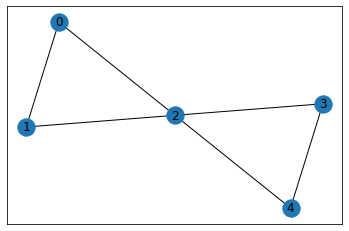

In [4]:
nx.draw_networkx(G_ibmq_5_yorktown)

To generate a random circuit, we use the randomCircuit() function. 
It takes the graph describing the quantum engine as its first argument.

This will only return an empty circuit.
Depth is:  0


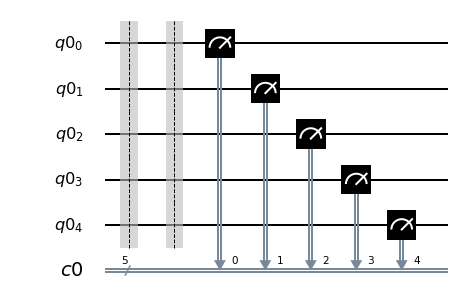

In [5]:
circ = randomCircuit(G_ibmq_5_yorktown)
circ.draw(output='mpl')

However, we did not specify that we want to have any gates in the circuit. To do that, we can set the number of CNOTs.

Constructing circuit with  9  CNOTs and arbitrary depth...
Depth is:  9


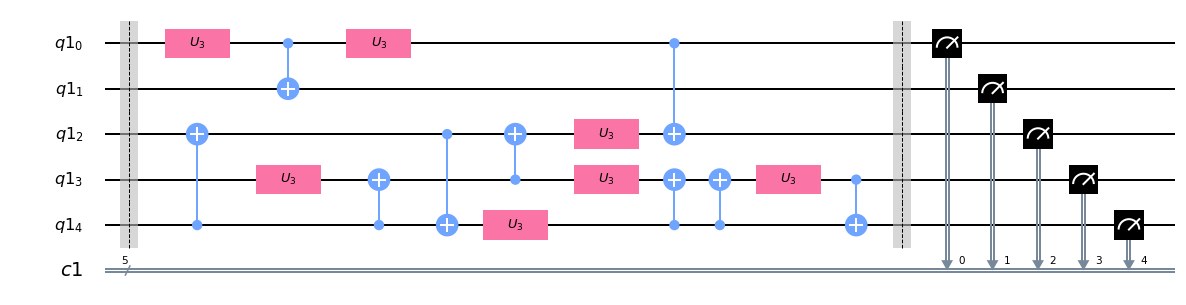

In [6]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=9)
circ.draw(output='mpl')

We can also specify the depth instead of the number of CNOTs:

Constructing circuit with arbitrarly many CNOTs and  10  depth...
Depth is:  10


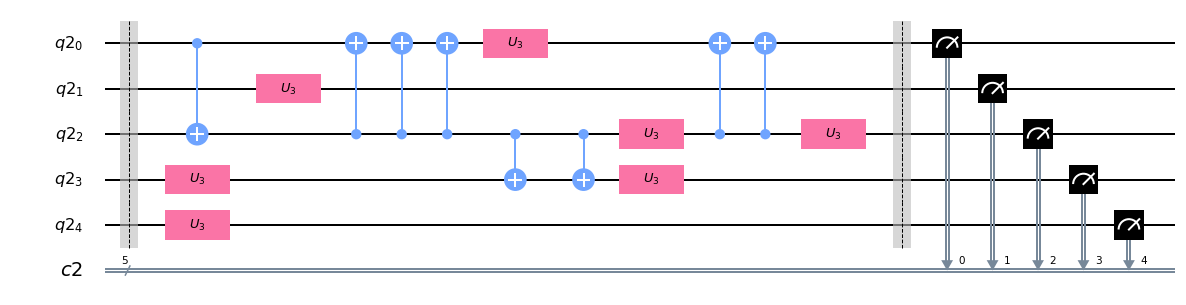

In [7]:
circ = randomCircuit(G_ibmq_5_yorktown, depth=10)
circ.draw(output='mpl')

If we specify both parameters, the algorithm will first try to determine if the chosen configuration is possible:

Impossible circuit parameters: depth is too low to fit all the required CNOTs into the given graph. Try again with different parameters.
Depth is:  0


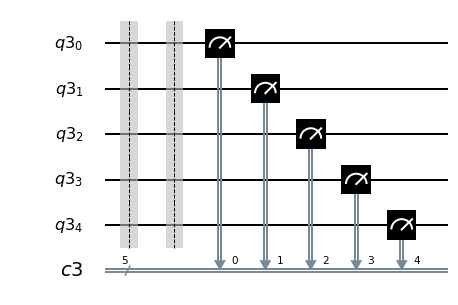

In [8]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=13, depth=2)
circ.draw(output='mpl')

Impossible circuit parameters: number of CNOTs is too low to reach the desired depth. Try again with different parameters.
Depth is:  0


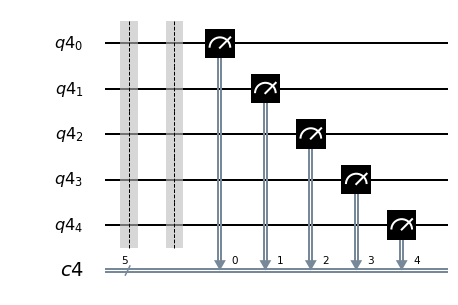

In [9]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=3, depth=9)
circ.draw(output='mpl')

If it is indeed possible, it will construct a random circuit with the given depth and number of CNOTs:

Constructing circuit with  14  CNOTs and  9  depth...
Preconstruction...
Successful at attempt  40
Constructing circuit...
Depth is:  9


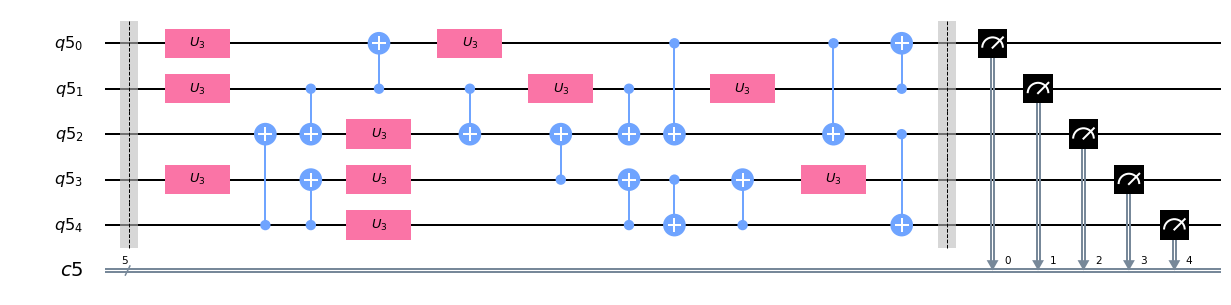

In [10]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=14, depth=9)
circ.draw(output='mpl')

Since it is sometimes difficult to see that the depth is indeed what it should be, we can construct the circuit with barriers:

Constructing circuit with  14  CNOTs and  9  depth...
Preconstruction...
Successful at attempt  30
Constructing circuit...
Depth is:  9


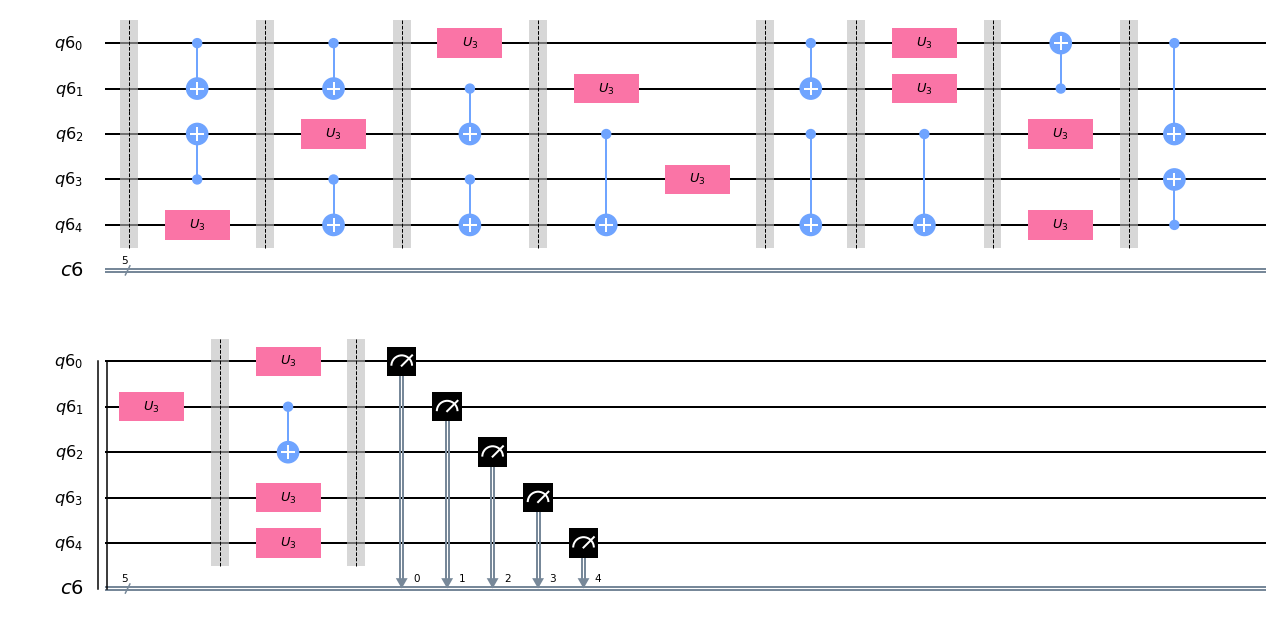

In [11]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=14, depth=9, barrier=True)
circ.draw(output='mpl')

Depending on the parameters, construction can take a while. This is because the algorithm has to generate lots of random circuits until one of them fits the specifications.
Sometimes it will simply give up after a large number of tries.

Constructing circuit with  16  CNOTs and  33  depth...
Preconstruction...
Sorry, unable to construct the circuit after  1742401  attempts. Try again with different parameters.
Depth is:  0


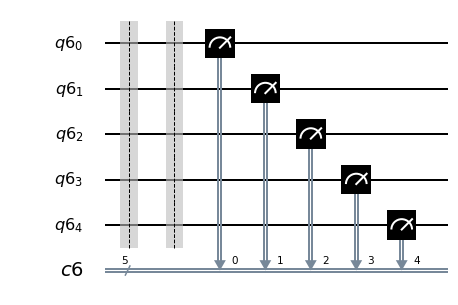

In [11]:
circ = randomCircuit(G_ibmq_5_yorktown, cnots=16, depth=33)
circ.draw(output='mpl')